In [1]:
import os, sys, math

from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

sys.path.insert(0,"/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/LibFolder")
from Lib_GeneralFunctions import *
from Lib_ProfilePlotting import *
from Lib_ProfileProcessing import *
from se2waveload import *
import pandas as pd
from scipy import fft


from matplotlib.gridspec import GridSpec


plt.style.use('seaborn-whitegrid')

from matplotlib import cm
from matplotlib.colors import ListedColormap
viridisBig = cm.get_cmap('viridis_r', 512)
cmap = ListedColormap(viridisBig(np.linspace(0.20, 1., 256)))


import time
start_time = time.time()

from matplotlib.lines import Line2D
from scipy import signal

In [2]:
# Function to calculate the analytical Kostrov Solution
def CalculateKostrovSolution(Time,Stress,mu, v,r):
    result = (24.0/(np.pi*5.0))*(Stress/mu)*np.sqrt((v**2)*(Time**2)-r**2)
    if math.isnan(result):
        return 0.0
    else:
        return result

# Function to calculate the root-mean-square of a target list of data against a target list of data
def rmse(predictions, targets):
    return np.sqrt(((np.asarray(predictions)-np.asarray(targets))**2).mean()).tolist()

# Function to filter using a Butterworth filter
def Butterworth(Signal, Type = "low",CutoffFrequency = 7., SamplingFrequency = 200):
    NormFrequency = CutoffFrequency / (SamplingFrequency / 2.0)
    
    b,a = signal.butter(1, NormFrequency, Type)
    output =  signal.filtfilt(b, a, np.asarray(Signal)).tolist()
    return output

# Function to extract h p delta values from the folder naming
def FilePath2hpdelta(SingleFile):
    head, tail = os.path.split(SingleFile)

    hpdelta = head.split("/")[-1].split("-")
    h_ref = int(''.join([s for s in hpdelta[0] if s.isdigit()]))
    p_ref = int(''.join([s for s in hpdelta[1] if s.isdigit()]))
    delta_ref = float(''.join([s for s in hpdelta[2] if (s.isdigit() or s == ".")]))
    
    return h_ref, p_ref, delta_ref


def CalculateFFT(Data, sampling = 0.005, TMax = 4.0):
    N=int(TMax/sampling)
    yf = fft(Data)
    xf = np.linspace(0.0, 1.0/(2.0*sampling), N//2)
    yf = 2.0/N * np.abs(yf[0:N//2])
    return(xf,yf)

In [3]:
# Class and functions to extract and plot Parameters of Interest for error analysis

class ReferenceStorage:
    def __init__(self):
        self.ReferenceName = ""
        self.ReferencePos = []
        
        self.ReferenceSlip = []
        self.ReferenceSlipRate = []
        self.ReferenceTime = []
        
        self.PeakSR = []
        self.PeakSRTime = []
        self.TailSR = []
        self.TailSRTime = []
        
        self.PT_SRdiff = []
        self.PT_SRdiffTime = []
        
        
    def StoreReference(self, RefSourceName, RefPosition, RefSlipData, RefSRData, RefTimeData, epsilon = 1e-3):
        self.ReferenceName = RefSourceName
        
        self.ReferencePos.append(RefPosition)
        
        self.ReferenceSlip.append(RefSlipData)
        self.ReferenceSlipRate.append(RefSRData)
        self.ReferenceTime.append(RefTimeData)
        
        
        # Peak Slip Rate and respective Timing
        Pidx = RefSRData.index(max(RefSRData))
        self.PeakSR.append(RefSRData[Pidx]) 
        self.PeakSRTime.append(RefTimeData[Pidx]) 
        
        # Tail Slip Rate and respective Timing
        Tidx = next((RefSRData.index(x) for x in RefSRData if x > epsilon), None)
        self.TailSR.append(RefSRData[Tidx]) 
        self.TailSRTime.append(RefTimeData[Tidx]) 
        
        self.PT_SRdiff.append(RefSRData[Pidx] - RefSRData[Tidx])
        self.PT_SRdiffTime.append(RefTimeData[Pidx] - RefTimeData[Tidx])

# Class to initialize, append and store an object to store the Variables of Interest
class VOI_TimeProfile:
    def __init__(self):
        self.P_Refinement = []
        self.H_Refinement = []
        self.delta_Refinement = []
        
        self.Coord = []
        
        
        self.PeakSlipRate = []
        self.PeakSlipRateTimeArrival = []
        
        self.TailSlipRate = []
        self.TailSlipRateTimeArrival = []
        
        self.PeakTailSR = []
        self.PeakTailSRTime = []

        
    #end __init__
    
    def __repr__(self):
        return "Number of stored -Variables Of Interest- is {}".format(self.NumStoredObjects())
    #end __repr__
    
    def __str__(self):
        TemplateText = "{idx}: p-ref: {p}, h-ref: {h}, delta-ref {delta}, Receiver Coord: {Coord}\n" 
        OutputText = [TemplateText.format(idx = idx, p = self.P_Refinement[idx],h = self.H_Refinement[idx], delta = self.delta_Refinement[idx],
                                          Coord = self.Coord[idx]) for idx in range(self.NumStoredObjects())]
        
        return "".join(OutputText)
    #end __str__
    
    
    def NumStoredObjects(self):
        return len(self.Coord)
    
    
    def GetPeakInList(self,TPOItemList,TPOItemTimeList):
        idx = TPOItemList.index(max(TPOItemList))
        
        PeakInList = TPOItemList[idx]
        PeakInListTimeArrival = TPOItemTimeList[idx]
        
        return PeakInList, PeakInListTimeArrival
    
    def GetFirstNonZeroInList(self, TPOItemList, TPOItemTimeList, epsilon=1e-3):
        idx = next((TPOItemList.index(x) for x in TPOItemList if x > epsilon), None)
        
        PeakSlipRate = TPOItemList[idx]
        PeakSlipRateTimeArrival = TPOItemTimeList[idx]
        
        return PeakSlipRate, PeakSlipRateTimeArrival
    
    def addNewItem(self, P_ref, H_ref, delta_ref, TPOItem, **kwargs):
        self.P_Refinement.append(P_ref)
        self.H_Refinement.append(H_ref)
        self.delta_Refinement.append(delta_ref)
        
        self.Coord.append(TPOItem.Coord[0])
        
        
        TailMagnitudeSR, TailTimingSR = self.GetFirstNonZeroInList(TPOItem.VelX, TPOItem.Time, **kwargs)
        PeakMagnitudeSR, PeakTimingSR = self.GetPeakInList(TPOItem.VelX, TPOItem.Time,)
        
        self.PeakSlipRate.append(PeakMagnitudeSR)
        self.PeakSlipRateTimeArrival.append(PeakTimingSR)
        
        self.TailSlipRate.append(TailMagnitudeSR)
        self.TailSlipRateTimeArrival.append(TailTimingSR)
        
        self.PeakTailSR.append(PeakMagnitudeSR - TailMagnitudeSR)
        self.PeakTailSRTime.append(PeakTimingSR - TailTimingSR)
        
    def ConvertPOI2Pandas(self):
        zippedList = list(zip(self.P_Refinement, self.H_Refinement, self.delta_Refinement, 
                             self.Coord, self.PeakSlipRate, self.PeakSlipRateTimeArrival, 
                             self.TailSlipRate, self.TailSlipRateTimeArrival,
                             self.PeakTailSR, self.PeakTailSRTime))
        
        ColumnName = ["pref", "href", "deltaref", "Loc", "PeakSR", "PeakSRtime", 
                      "TailSR", "TailSRtime", "PTSRdiff", "PTSRtimediff"]
        
        dfObject = pd.DataFrame(zippedList, columns= ColumnName)
        
        return dfObject
    

def Fill_VoiObject(ListOfFolders,VOI_Object):
    for SingleFile in ListOfFolders:
        h_ref, p_ref, delta_ref = FilePath2hpdelta(SingleFile)

        head, tail = os.path.split(SingleFile)
        ListOfTPObjects = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        for idx, STP in enumerate(ListOfTPObjects):
            VOI_Object.addNewItem(p_ref, h_ref, delta_ref, STP)   

In [4]:

def PlotBimatReference(ax, path, SlipSlipRate):
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    for NumStat in range(1,5):
        Station = pd.read_csv(path + "Bimat/pcsi_SSC.obs{}".format(NumStat), delimiter=r"\s+",header=None,
                             names=["time (s)" , "slip rate (m/s)", "slip (m)", "shear stress (Pa)", "normal stress (Pa)","strength (Pa)"])
        
        ax.plot(Station["time (s)"],Butterworth(Station[FileNameDict[SlipSlipRate]]), c = "k", ls= "-", zorder=1)
    ax.set_xlabel("time (s)")
    ax.set_ylabel(FileNameDict[SlipSlipRate])


def PlotSem2dpackReference(ax, path, SlipSlipRate):
    FileNameDict = {"Slip" : "slip", "SlipRate" : "sr", "Shear":"sxy"}
    ListReference = sorted(glob(path+"sem2dpack/sem2d-{}-*.txt".format(FileNameDict[SlipSlipRate])))
    
    for idx, item in enumerate(ListReference):
        line = pd.read_csv(item,header=None)
        
        if SlipSlipRate=="Shear":
            line[1] = line[1]*10e5
        ax.plot(line[0],Butterworth(line[1]), label = "", c = "k", ls = "-", zorder=1)
        
    ax.set_xlabel("time (s)")
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    ax.set_ylabel(FileNameDict[SlipSlipRate])
    
def PlotHandPickedReference(ax, path, SlipSlipRate):
    ListReference = sorted(glob(path + "HandPicking/{}/".format(SlipSlipRate)+"*.csv"))

    for idx, item in enumerate(ListReference):
        line = pd.read_csv(item)
        ax.plot(line["X"],line["Y"],c = "k", label = "", ls = "-", zorder=1)
        
    ax.set_xlabel("time (s)")
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    ax.set_ylabel(FileNameDict[SlipSlipRate])    
    
def PlotReference(ax,SlipSlipRate):
    Stress = 10.0e6 
    ElasticShearModulus = 13.333e9
    Velocity = 2.0e3
    
    TimeList = np.arange(0, 5, 0.01).tolist()
    
    if SlipSlipRate=="Slip":
        for r in [0,2000,4000,6000,8000]:
            Slip = [CalculateKostrovSolution(Time,Stress,ElasticShearModulus, Velocity, r) for Time in TimeList]
            ax.plot(TimeList,Slip,ls="-",c="k", lw=1, zorder=1)
    elif SlipSlipRate=="SlipRate":
        for r in [0,2000,4000,6000,8000]:
            Slip = [CalculateKostrovSolution(Time,Stress,ElasticShearModulus, Velocity, r) for Time in TimeList]
            SlipRate = np.gradient(Slip, TimeList[1]-TimeList[0],edge_order=2) 
            ax.plot(TimeList, SlipRate, ls = "-", c = "k", lw = 1, zorder=1)
  

In [5]:
# List of functions related to loading and plotting a slip/ slip rate reference. 
# This reference can be extracted from the output of either Bimat or sem2dpack from Ampuero's programs
# For these plots, the filename is hard-coded
# also at the end is the legend style for reference vs colors for the receivers
    

def PlotBimatReference(ax, path, SlipSlipRate):
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    for NumStat in range(1,5):
        Station = pd.read_csv(path + "Bimat/pcsi_SSC.obs{}".format(NumStat), delimiter=r"\s+",header=None,
                             names=["time (s)" , "slip rate (m/s)", "slip (m)", "shear stress (Pa)", "normal stress (Pa)","strength (Pa)"])
        
        ax.plot(Station["time (s)"],Butterworth(Station[FileNameDict[SlipSlipRate]]), c = "k", ls= "-", zorder=1)
    ax.set_xlabel("time (s)")
    ax.set_ylabel(FileNameDict[SlipSlipRate])


def PlotSem2dpackReference(ax, path, SlipSlipRate):
    FileNameDict = {"Slip" : "slip", "SlipRate" : "sr", "Shear":"sxy"}
    ListReference = sorted(glob(path+"sem2dpack/sem2d-{}-*.txt".format(FileNameDict[SlipSlipRate])))
    
    for idx, item in enumerate(ListReference):
        line = pd.read_csv(item,header=None)
        
        if SlipSlipRate=="Shear":
            line[1] = line[1]*10e5
        ax.plot(line[0],Butterworth(line[1]), label = "", c = "k", ls = "-", zorder=1)
        
    ax.set_xlabel("time (s)")
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    ax.set_ylabel(FileNameDict[SlipSlipRate])
    
def PlotHandPickedReference(ax, path, SlipSlipRate):
    ListReference = sorted(glob(path + "HandPicking/{}/".format(SlipSlipRate)+"*.csv"))

    for idx, item in enumerate(ListReference):
        line = pd.read_csv(item)
        ax.plot(line["X"],line["Y"],c = "k", label = "", ls = "-", zorder=1)
        
    ax.set_xlabel("time (s)")
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    ax.set_ylabel(FileNameDict[SlipSlipRate])    
    
def PlotReference(ax,SlipSlipRate):
    Stress = 10.0e6 
    ElasticShearModulus = 13.333e9
    Velocity = 2.0e3
    
    TimeList = np.arange(0, 5, 0.01).tolist()
    
    if SlipSlipRate=="Slip":
        for r in [0,2000,4000,6000,8000]:
            Slip = [CalculateKostrovSolution(Time,Stress,ElasticShearModulus, Velocity, r) for Time in TimeList]
            ax.plot(TimeList,Slip,ls="-",c="k", lw=1, zorder=1)
    elif SlipSlipRate=="SlipRate":
        for r in [0,2000,4000,6000,8000]:
            Slip = [CalculateKostrovSolution(Time,Stress,ElasticShearModulus, Velocity, r) for Time in TimeList]
            SlipRate = np.gradient(Slip, TimeList[1]-TimeList[0],edge_order=2) 
            ax.plot(TimeList, SlipRate, ls = "-", c = "k", lw = 1, zorder=1)
  
# Here are the style definition and legend functions

def addRefnColorLegend(ax,SlipSlipRate,Legend=True):
    Refpath ="/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/Reference/"
    
    #PlotReference(ax,SlipSlipRate)
    PlotSem2dpackReference(ax, Refpath, SlipSlipRate)
    #PlotHandPickedReference(ax, Refpath, SlipSlipRate)
    custom_lines = [Line2D([0],[0], c="k", ls= "-", lw=2)]
    [custom_lines.append(Line2D([0],[0], c = cmap(numCol/4), ls= "-", lw=2)) for numCol in range(5)]
    if (Legend):
        legend2 = plt.legend(custom_lines, ['Reference', '0m', '2000m','4000m','6000m', '8000m'],loc=1)
        ax.add_artist(legend2)

In [6]:

def PlotTimeProfileSet(ax, Set,SlipSlipRate,title,Filtered = False, absolute = False, **kwargs):
    UnitsDict = {"Slip" : "Slip [m]", "SlipRate" : "Slip Rate [m/s]"}
    
    ax.set(xlabel = 'Time [s]', ylabel = UnitsDict[SlipSlipRate], 
           title = title)
    
    OrdinateVariableList=[]
    for idx,item in enumerate(Set):
        
        if (SlipSlipRate == "Slip"):
            OrdinateVariableList.append([a for a in item.DispX]) 
        elif (SlipSlipRate == "SlipRate"):
            OrdinateVariableList.append([a for a in item.VelX])

        if (Filtered):
            OrdinateVariableList[idx] = [a for a in Butterworth(OrdinateVariableList[idx])]

        if (absolute):
            OrdinateVariableList[idx] = [abs(a) for a in OrdinateVariableList[idx]]

    for idx,item in enumerate(Set):
        ax.plot(item.Time, OrdinateVariableList[idx], c = cmap(item.Coord[0]/8000), label = "{x}m".format(x = item.Coord[0]), **kwargs)
        

def InitDefaultFigure():
    try:
        fig = plt.figure(figsize = (10,5), constrained_layout=True)
        gs = fig.add_gridspec(1, 1)
        ax = fig.add_subplot(gs[:, :])
    except:
        fig = plt.figure(figsize = (10,5))
        ax = fig.add_subplot(1,1,1)
        
    ax.set_xlim([0,4])
    ax.set_ylim([-1,10])
    return fig, ax
    

def PlotSpecificLegend(ax, ListOfFiles,SlipSlipRate,title,LegendNamesList,Filtered=True,**kwargs):
    
    for iidx,SingleFile in enumerate(ListOfFiles):
        head, tail = os.path.split(SingleFile)
        File = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        PlotTimeProfileSet(ax, File, SlipSlipRate, title,Filtered, zorder = iidx + 2,**kwargs )
        
        hpd = FilePath2hpdelta(SingleFile)
        
    addRefnColorLegend(ax,SlipSlipRate)    
    return ax

In [7]:
def PlotTimeProfileSetFlex(ax, Set,SlipSlipRate,title,Filtered = False, absolute = False, **kwargs):
    UnitsDict = {"Slip" : "Slip [m]", "SlipRate" : "Slip Rate [m/s]"}
    
    ax.set(xlabel = 'Time [s]', ylabel = UnitsDict[SlipSlipRate], 
           title = title)
    
    OrdinateVariableList=[]
    for idx,item in enumerate(Set):
        
        if (SlipSlipRate == "Slip"):
            OrdinateVariableList.append([a for a in item.DispX]) 
        elif (SlipSlipRate == "SlipRate"):
            OrdinateVariableList.append([a for a in item.VelX])

        if (Filtered):
            OrdinateVariableList[idx] = [a for a in Butterworth(OrdinateVariableList[idx])]

        if (absolute):
            OrdinateVariableList[idx] = [abs(a) for a in OrdinateVariableList[idx]]

    for idx,item in enumerate(Set):
        ax.plot(item.Time, OrdinateVariableList[idx], **kwargs)

def PlotFlexSpecificLegend(ax, ListOfFiles,SlipSlipRate,title,Filtered=True,**kwargs):
    
    for iidx,SingleFile in enumerate(ListOfFiles):
        head, tail = os.path.split(SingleFile)
        File = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        PlotTimeProfileSetFlex(ax, File, SlipSlipRate, title,Filtered,
                               zorder = iidx + 2, c = cmap(iidx/len(ListOfFolders)),
                               **kwargs )  
    addRefnColorLegend(ax,SlipSlipRate,Legend=False)    

    return ax

# Checkpoint: Plots after choosing a blending function
The following plots are the weird blending function stored on the branch 

$nicolas/WeirdAltBlend$

PreA is a shifting function, while PreB is non shifted. Both weightings have a negative component

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200723/100dx-3p-50.005delta_PreA/TPList_t8000_d50.005.pickle


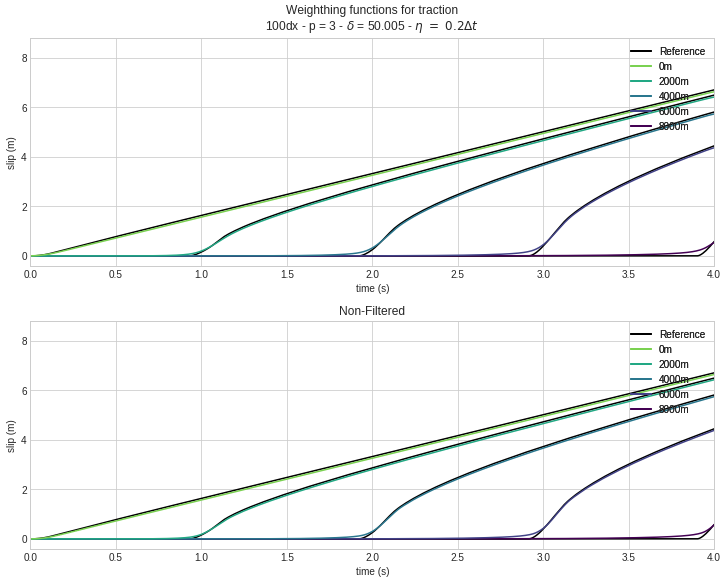

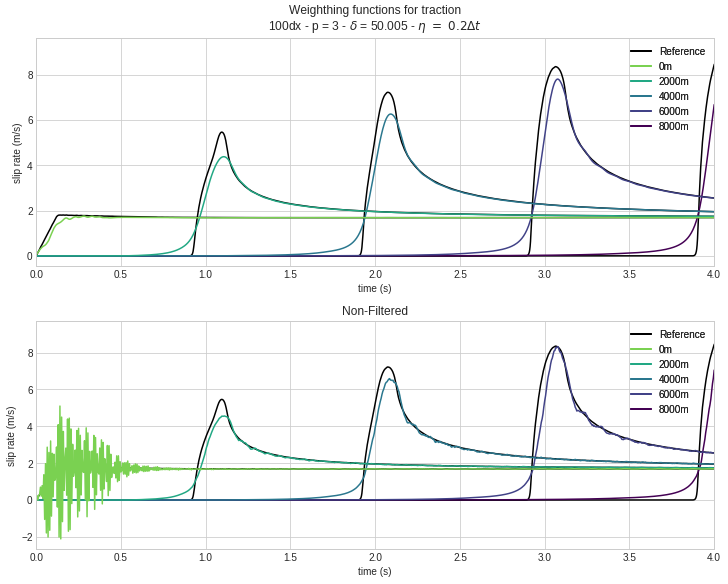

In [8]:
LegendNamesList=["nada"]
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200723/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))[:1]
[print(A) for A in ListOfFolders]


fig = plt.figure(figsize = (10,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim([0,4])

if ListOfFolders != []:
    PlotSpecificLegend(ax1,ListOfFolders,"Slip","Weighthing functions for traction\n100dx - p = 3 - $\delta$ = 50.005 - $\eta\ =\ 0.2\Delta t$",LegendNamesList)

ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlim([0,4])
if ListOfFolders != []:
    PlotSpecificLegend(ax2,ListOfFolders,"Slip","Non-Filtered",LegendNamesList,Filtered=False)



fig = plt.figure(figsize = (10,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim([0,4])

if ListOfFolders != []:
    PlotSpecificLegend(ax1,ListOfFolders,"SlipRate","Weighthing functions for traction\n100dx - p = 3 - $\delta$ = 50.005 - $\eta\ =\ 0.2\Delta t$",LegendNamesList)

ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlim([0,4])
if ListOfFolders != []:
    PlotSpecificLegend(ax2,ListOfFolders,"SlipRate","Non-Filtered",LegendNamesList,Filtered=False)


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200723/100dx-3p-50.005delta_PreA/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200723/100dx-3p-50.005delta_PreB/TPList_t8000_d50.005.pickle


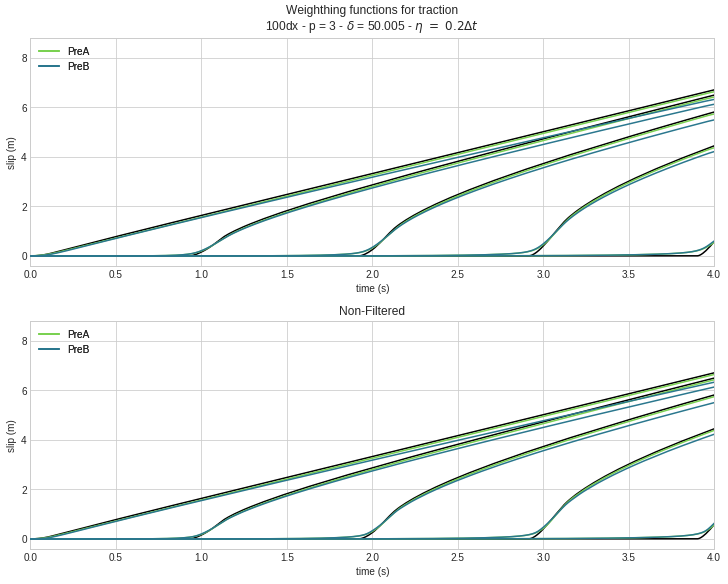

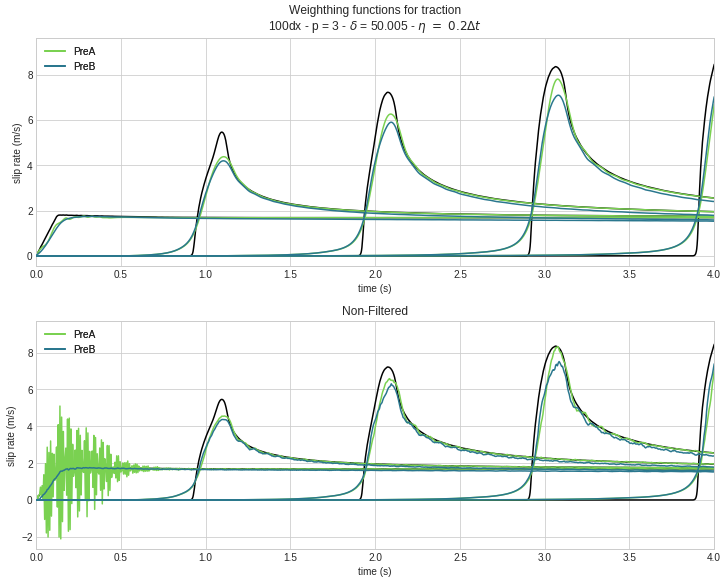

In [9]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200723/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]

#--------------------------------------------
def LinesNames():
    custom_lines=[]
    [custom_lines.append(Line2D([0],[0], c = cmap(idx/len(ListOfFolders)), lw=2)) for idx,Value in enumerate(ListOfFolders)]
    legend2 = plt.legend(custom_lines, ['PreA', 'PreB'],loc=2)
    return legend2
#--------------------------------------------



fig = plt.figure(figsize = (10,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim([0,4])
legend2 = LinesNames(); ax1.add_artist(legend2)
if ListOfFolders != []:
    PlotFlexSpecificLegend(ax1,ListOfFolders,"Slip","Weighthing functions for traction\n100dx - p = 3 - $\delta$ = 50.005 - $\eta\ =\ 0.2\Delta t$",)

ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlim([0,4])
legend2 = LinesNames(); ax2.add_artist(legend2)
if ListOfFolders != []:
    PlotFlexSpecificLegend(ax2,ListOfFolders,"Slip","Non-Filtered",Filtered=False)



fig = plt.figure(figsize = (10,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim([0,4])
legend2 = LinesNames(); ax1.add_artist(legend2)
if ListOfFolders != []:
    PlotFlexSpecificLegend(ax1,ListOfFolders,"SlipRate","Weighthing functions for traction\n100dx - p = 3 - $\delta$ = 50.005 - $\eta\ =\ 0.2\Delta t$")

ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlim([0,4])
legend2 = LinesNames(); ax2.add_artist(legend2)   
if ListOfFolders != []:
    PlotFlexSpecificLegend(ax2,ListOfFolders,"SlipRate","Non-Filtered",Filtered=False)
 


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200726/50dx-4p-25.003delta/TPList_t40000_d25.003.pickle


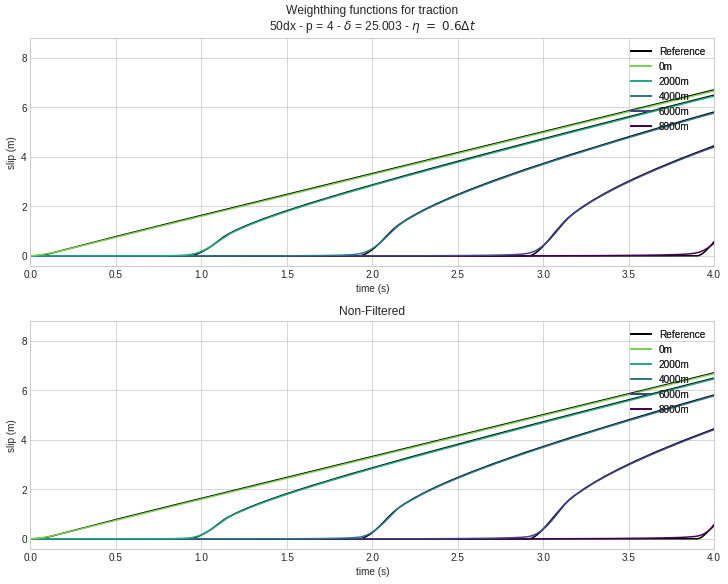

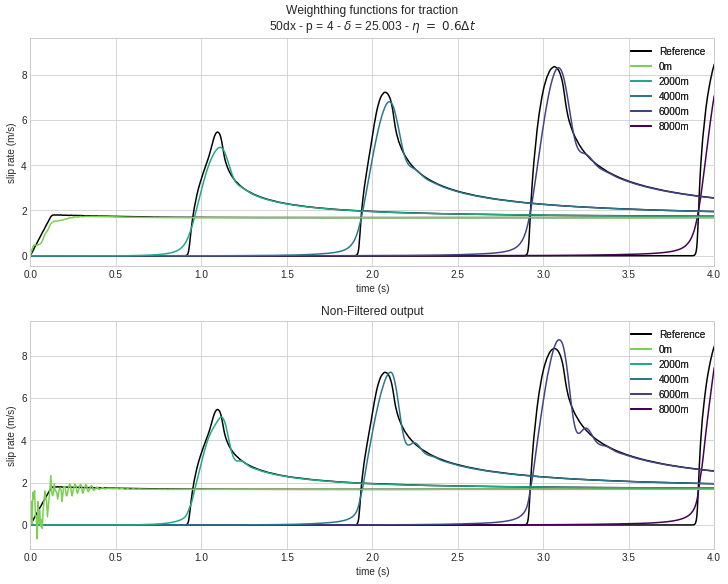

In [10]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200726/"

ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]


fig = plt.figure(figsize = (10,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim([0,4])

if ListOfFolders != []:
    PlotSpecificLegend(ax1,ListOfFolders,"Slip","Weighthing functions for traction\n50dx - p = 4 - $\delta$ = 25.003 - $\eta\ =\ 0.6\Delta t$",LegendNamesList)

ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlim([0,4])
if ListOfFolders != []:
    PlotSpecificLegend(ax2,ListOfFolders,"Slip","Non-Filtered",LegendNamesList,Filtered=False)



fig = plt.figure(figsize = (10,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim([0,4])

if ListOfFolders != []:
    PlotSpecificLegend(ax1,ListOfFolders,"SlipRate","Weighthing functions for traction\n50dx - p = 4 - $\delta$ = 25.003 - $\eta\ =\ 0.6\Delta t$",LegendNamesList)

ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlim([0,4])
if ListOfFolders != []:
    PlotSpecificLegend(ax2, ListOfFolders, "SlipRate", "Non-Filtered output", LegendNamesList, Filtered = False)


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200728/25dx-2p-12.501delta/TPList_t8000_d12.501.pickle


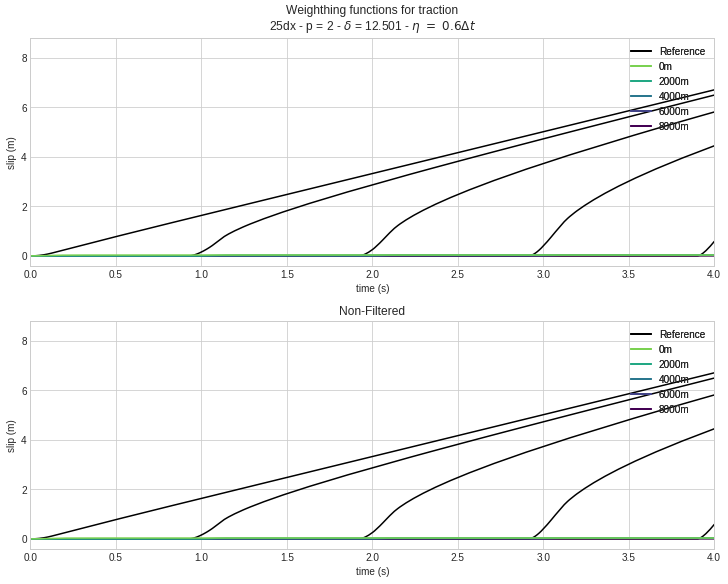

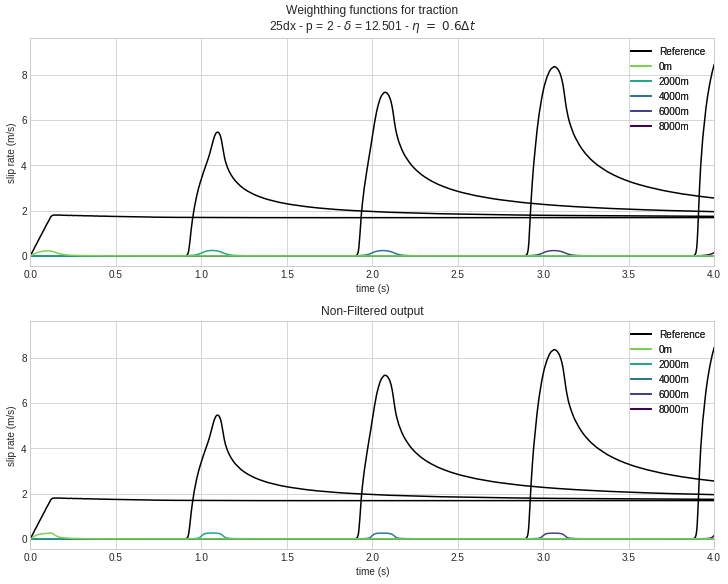

In [11]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200728/"

ListOfFolders = sorted(glob(path+"*/*.pickle"))[:1]
[print(A) for A in ListOfFolders]


fig = plt.figure(figsize = (10,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim([0,4])

if ListOfFolders != []:
    PlotSpecificLegend(ax1,ListOfFolders,"Slip","Weighthing functions for traction\n25dx - p = 2 - $\delta$ = 12.501 - $\eta\ =\ 0.6\Delta t$",LegendNamesList)

ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlim([0,4])
if ListOfFolders != []:
    PlotSpecificLegend(ax2,ListOfFolders,"Slip","Non-Filtered",LegendNamesList,Filtered=False)



fig = plt.figure(figsize = (10,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim([0,4])

if ListOfFolders != []:
    PlotSpecificLegend(ax1,ListOfFolders,"SlipRate","Weighthing functions for traction\n25dx - p = 2 - $\delta$ = 12.501 - $\eta\ =\ 0.6\Delta t$",LegendNamesList)

ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlim([0,4])
if ListOfFolders != []:
    PlotSpecificLegend(ax2, ListOfFolders, "SlipRate", "Non-Filtered output", LegendNamesList, Filtered = False)


# Tilting Experiments

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200731/100dx-2p-50.005delta_Horizontal/TPList_t4000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200731/100dx-2p-50.005delta_TiltingZero/TPList_t4000_d50.005.pickle


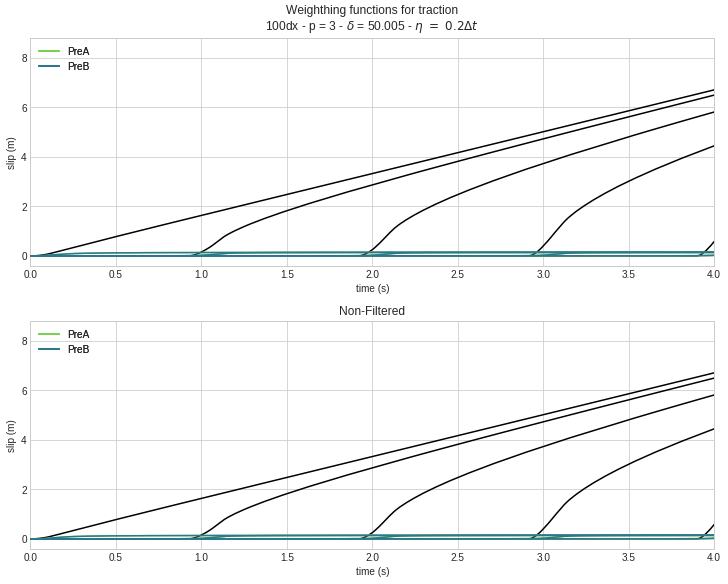

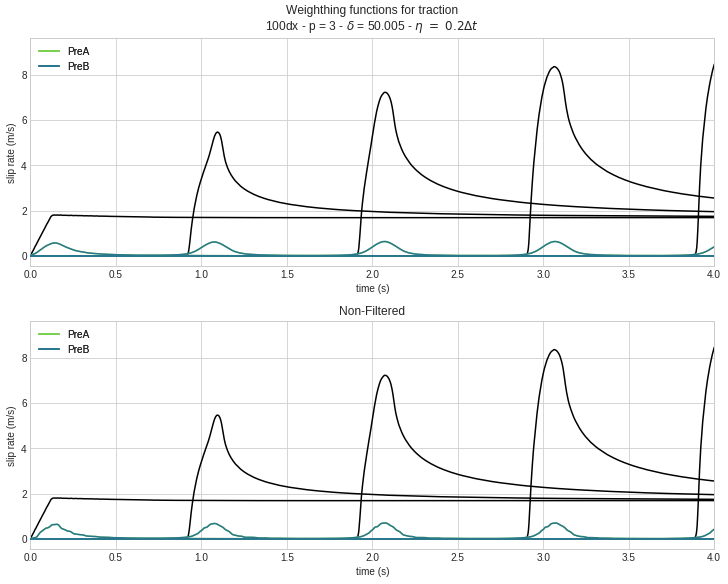

In [12]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200731/"

ListOfFolders = sorted(glob(path+"*/*.pickle"))[:2]
[print(A) for A in ListOfFolders]

#--------------------------------------------
def LinesNames():
    custom_lines=[]
    [custom_lines.append(Line2D([0],[0], c = cmap(idx/len(ListOfFolders)), lw=2)) for idx,Value in enumerate(ListOfFolders)]
    legend2 = plt.legend(custom_lines, ['PreA', 'PreB'],loc=2)
    return legend2
#--------------------------------------------



fig = plt.figure(figsize = (10,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim([0,4])
legend2 = LinesNames(); ax1.add_artist(legend2)
if ListOfFolders != []:
    PlotFlexSpecificLegend(ax1,ListOfFolders,"Slip","Weighthing functions for traction\n100dx - p = 3 - $\delta$ = 50.005 - $\eta\ =\ 0.2\Delta t$",)

ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlim([0,4])
legend2 = LinesNames(); ax2.add_artist(legend2)
if ListOfFolders != []:
    PlotFlexSpecificLegend(ax2,ListOfFolders,"Slip","Non-Filtered",Filtered=False)



fig = plt.figure(figsize = (10,8), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim([0,4])
legend2 = LinesNames(); ax1.add_artist(legend2)
if ListOfFolders != []:
    PlotFlexSpecificLegend(ax1,ListOfFolders,"SlipRate","Weighthing functions for traction\n100dx - p = 3 - $\delta$ = 50.005 - $\eta\ =\ 0.2\Delta t$")

ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlim([0,4])
legend2 = LinesNames(); ax2.add_artist(legend2)   
if ListOfFolders != []:
    PlotFlexSpecificLegend(ax2,ListOfFolders,"SlipRate","Non-Filtered",Filtered=False)
 